# Estimator of the Grouping Loss

This package aims at estimating the grouping loss of a probabilistic classifier following the estimation procedure defined in [1].

[1] Alexandre Perez-Lebel, Marine Le Morvan, and Gaël Varoquaux. "Beyond calibration: estimating the grouping loss of modern neural networks." (ICLR 2023).
https://doi.org/10.48550/arxiv.2210.16315

## Load a probabilistic classifier

As an example, we fit a logistic regression on a binary classification dataset from scikit-learn. The classifier implements a `predict_proba` method to estimate the posterior probabilities of the classes.

In [1]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=20000, n_informative=10, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

est = LogisticRegression()
est.fit(X_train, y_train)
est.predict_proba(X_test)[:, 1]


array([0.12020287, 0.76298063, 0.03892254, ..., 0.03135261, 0.91760703,
       0.04667157])

## 

### Calibration

We first evaluate the calibration of the classifier. We observe below that the classifier is pretty well calibrated out of the box.

[Text(0.5, 1.0, 'Calibration curve')]

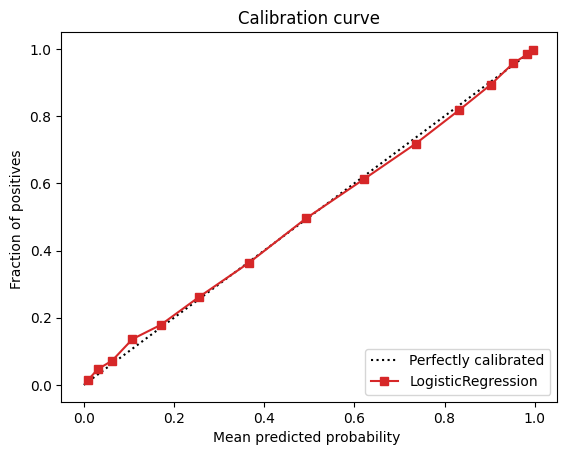

In [2]:
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve


y_prob_test = est.predict_proba(X_test)[:, 1]
prob_true, prob_pred = calibration_curve(y_test, y_prob_test, n_bins=15, strategy="quantile")
disp = CalibrationDisplay(prob_true, prob_pred, y_prob_test, estimator_name=est.__class__.__name__)
disp.plot(color="tab:red")
disp.ax_.set(
    title="Calibration curve"
)



However, errors on individual posterior probabilities remains, but are blind to calibration estimation. This is revealed by the grouping loss estimation we investigate below.

## Estimation of the grouping loss of the classifier

### Use pre-defined partitioner

GLEstimator()
  Scoring Rule      : brier
  Grouping loss     : 0.0534
   ↳ Uncorrected GL : 0.0685
   ↳ Bias           : 0.0143
   ↳ Binning induced: 0.0008



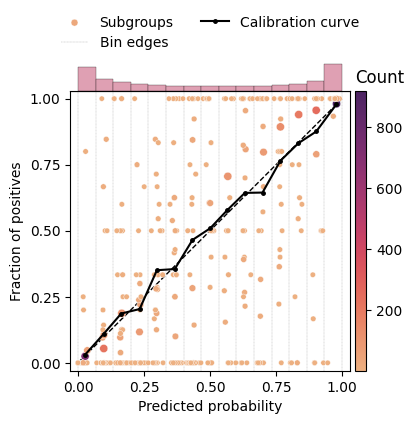

In [3]:
from glest.core import GLEstimator

glest = GLEstimator(est, partitioner="decision_tree", train_size=0.5, random_state=0)
glest.fit(X_test, y_test)
fig = glest.plot(fig_kw=dict(figsize=(4, 4)))
print(glest)


### Customize binning
To allow more flexibility on the binning (number of bins and binning strategy), use the Partitioner.from_name classmethod to specify the number of bins and binning strategy to use.

GLEstimator()
  Scoring Rule      : brier
  Grouping loss     : 0.0750
   ↳ Uncorrected GL : 0.0876
   ↳ Bias           : 0.0105
   ↳ Binning induced: 0.0021



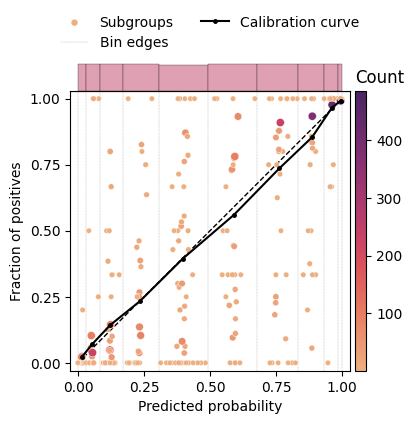

In [4]:
from glest.core import Partitioner

partitioner = Partitioner.from_name("decision_tree", n_bins=10, strategy="quantile")

glest = GLEstimator(est, partitioner=partitioner, train_size=0.5, random_state=0)
glest.fit(X_test, y_test)
fig = glest.plot(fig_kw=dict(figsize=(4, 4)))
print(glest)


### Customization of the partitioner
You can also specify a custom estimator to partition the feature space. You must specify the method that should be called to retrieve the partition assignments.

GLEstimator()
  Scoring Rule      : brier
  Grouping loss     : 0.0761
   ↳ Uncorrected GL : 0.0888
   ↳ Bias           : 0.0107
   ↳ Binning induced: 0.0021



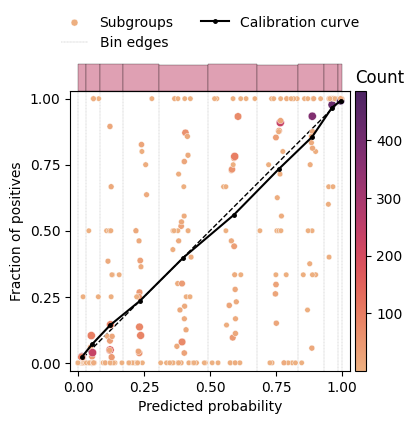

In [5]:
from sklearn.tree import DecisionTreeClassifier

partitioner_est = DecisionTreeClassifier(max_depth=10, random_state=0)
partitioner = Partitioner(partitioner_est, n_bins=10, strategy="quantile", predict_method="apply")

glest = GLEstimator(est, partitioner=partitioner, train_size=0.5, random_state=0)
glest.fit(X_test, y_test)
fig = glest.plot(fig_kw=dict(figsize=(4, 4)))
print(glest)


GLEstimator()
  Scoring Rule      : brier
  Grouping loss     : 0.0099
   ↳ Uncorrected GL : 0.0134
   ↳ Bias           : 0.0014
   ↳ Binning induced: 0.0021



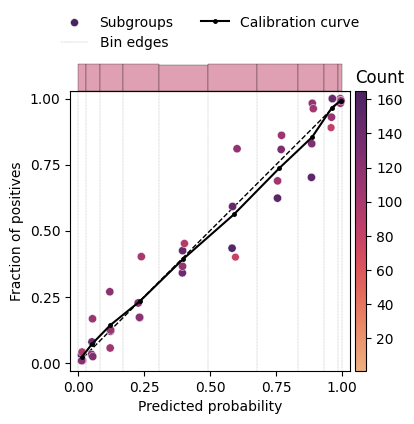

In [6]:
from sklearn.cluster import KMeans

partitioner_est = KMeans(n_clusters=4, random_state=0, n_init="auto")
partitioner = Partitioner(partitioner_est, n_bins=10, strategy="quantile", predict_method="predict")

glest = GLEstimator(est, partitioner=partitioner, train_size=0.5, random_state=0)
glest.fit(X_test, y_test)
fig = glest.plot(fig_kw=dict(figsize=(4, 4)))
print(glest)


### Custom split

By default, the estimator split the data internally to avoid overfitting the partition and the evaluation based on the `train_size` argument. You can customize how this split is made by passing directly the test data with the `test_data` argument of `GLEstimator.fit`. For example with `glest.fit(X1, y1, test_data=(X2, y2))`, the partitions will be fitted on `(X1, y1)` and the grouping loss will be evaluated on `(X2, y2)`.

GLEstimator()
  Scoring Rule      : brier
  Grouping loss     : 0.0869
   ↳ Uncorrected GL : 0.1040
   ↳ Bias           : 0.0148
   ↳ Binning induced: 0.0022



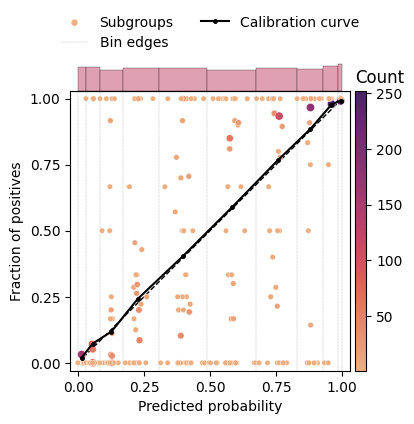

In [7]:
from sklearn.model_selection import train_test_split

X1, X2, y1, y2 = train_test_split(X_test, y_test, random_state=0)

partitioner_est = DecisionTreeClassifier(max_depth=10, random_state=0)
partitioner = Partitioner(partitioner_est, n_bins=10, strategy="quantile", predict_method="apply")

glest = GLEstimator(est, partitioner=partitioner, random_state=0)
glest.fit(X1, y1, test_data=(X2, y2))
fig = glest.plot(fig_kw=dict(figsize=(4, 4)))
print(glest)


### Pass the estimated probabilities manually

In some situations, the probabilistic classifier you want to evaluate is not easily accessible under the form of a class with the `predict_proba` method. For example, when working with large models and data, running `predict_proba` each time is too resource-intensive. A solution would be to do a single pass on the data and to store the probabilities on disk. To still be able to use this package and evaluate the grouping loss, the GLEstimator accepts an array of probabilities `y_proba` as the `fitted_estimator` argument. The only constraint is that the `GLEstimator.fit` method should be called on the corresponding `(X, y)` data that generated the `y_proba` array. The estimator checks for shape mismatches, but it is the responsibility of the user to ensure both are matching: i.e. `y_proba[i]` is the output of the classifier for `X[i]`.

GLEstimator()
  Scoring Rule      : brier
  Grouping loss     : 0.0690
   ↳ Uncorrected GL : 0.0932
   ↳ Bias           : 0.0234
   ↳ Binning induced: 0.0008



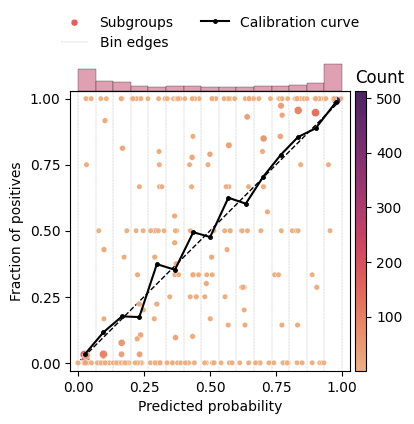

In [8]:

y_proba = est.predict_proba(X_test)

X1, X2, y1, y2, y_proba1, y_proba2 = train_test_split(X_test, y_test, y_proba, random_state=0)
glest = GLEstimator(y_proba1, partitioner="decision_tree", random_state=0)
glest.fit(X1, y1, test_data=(X2, y2, y_proba2))
fig = glest.plot(fig_kw=dict(figsize=(4, 4)))
print(glest)


### Manual partitioning
Similarly, the partitions can be set explicitly using the `partition` argument of the `GLEstimator.fit` method. This is useful for example if the groups are not defined from a fit/predict procedure. For example, one can use an explicit feature of the covariates (eg. socio-demographics).

In [9]:
import numpy as np

def quantile_partition(x, n):
    quantiles = np.quantile(x, np.linspace(0, 1, n+1))
    quantile_ids = np.digitize(x, quantiles, right=False)
    quantile_ids[quantile_ids == n] = n - 1
    return quantile_ids

partition = quantile_partition(X[:, 0], n=10)


GLEstimator()
  Scoring Rule      : brier
  Grouping loss     : 0.0066
   ↳ Uncorrected GL : 0.0091
   ↳ Bias           : 0.0019
   ↳ Binning induced: 0.0007



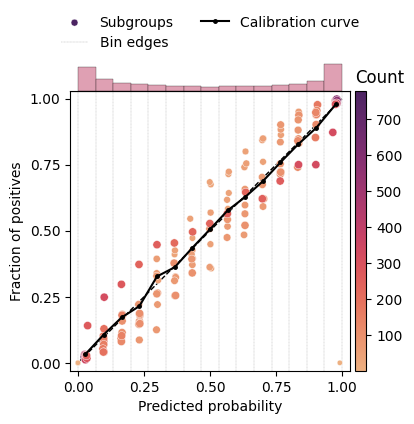

In [10]:
glest = GLEstimator(est, None)
glest.fit(X, y, partition=partition)
glest.plot(fig_kw=dict(figsize=(4, 4)))
print(glest)


It is still possible to adjust the binning strategy using an empty Partitioner.

GLEstimator()
  Scoring Rule      : brier
  Grouping loss     : 0.0052
   ↳ Uncorrected GL : 0.0082
   ↳ Bias           : 0.0009
   ↳ Binning induced: 0.0022



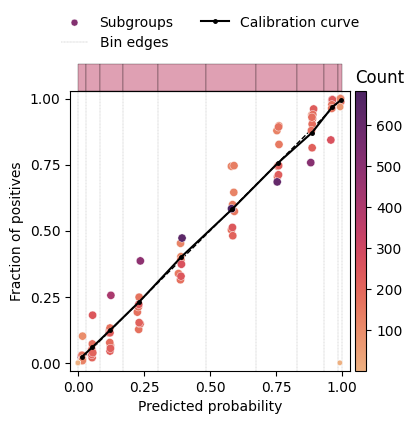

In [11]:
partitioner = Partitioner.from_name(None, n_bins=10, strategy="quantile")
glest = GLEstimator(est, partitioner)
glest.fit(X, y, partition=partition)
glest.plot(fig_kw=dict(figsize=(4, 4)))
print(glest)


### Cross-validate the estimation

To account for variance in the estimation procedure, use `GLEstimatorCV`. Set the `cv` parameter to the desired splitting method. One GLEstimator will be fitted per split and stored in `GLEstimatorCV.glests_`.

In [12]:
from glest.core import GLEstimatorCV

glest_cv = GLEstimatorCV(est, "decision_tree", verbose=1, random_state=0).fit(X, y)
print(glest_cv)


Split 1/5
Split 2/5
Split 3/5
Split 4/5
Split 5/5
GLEstimatorCV()
  Scoring rule      : brier
  Grouping loss     : 0.0824 (0.0086)
   ↳ Uncorrected GL : 0.1020 (0.0084)
   ↳ Bias           : 0.0188 (0.0009)
   ↳ Binning induced: 0.0008 (0.0001)



In [13]:
for glest in glest_cv.glests_:
    print(glest)


GLEstimator()
  Scoring Rule      : brier
  Grouping loss     : 0.0927
   ↳ Uncorrected GL : 0.1115
   ↳ Bias           : 0.0180
   ↳ Binning induced: 0.0008

GLEstimator()
  Scoring Rule      : brier
  Grouping loss     : 0.0927
   ↳ Uncorrected GL : 0.1129
   ↳ Bias           : 0.0194
   ↳ Binning induced: 0.0008

GLEstimator()
  Scoring Rule      : brier
  Grouping loss     : 0.0736
   ↳ Uncorrected GL : 0.0932
   ↳ Bias           : 0.0189
   ↳ Binning induced: 0.0007

GLEstimator()
  Scoring Rule      : brier
  Grouping loss     : 0.0785
   ↳ Uncorrected GL : 0.0970
   ↳ Bias           : 0.0177
   ↳ Binning induced: 0.0008

GLEstimator()
  Scoring Rule      : brier
  Grouping loss     : 0.0745
   ↳ Uncorrected GL : 0.0953
   ↳ Bias           : 0.0201
   ↳ Binning induced: 0.0007



## Change proper scoring rule

The grouping loss is given relative to the choice of a proper scoring rule. By default the Brier score is used. This can be changed in several ways shown below. However, the debiasing procedure is only implemented for the Brier score.


In [14]:
glest.metrics("log")


/Users/alexandreperez/dev/rep/inr-phd-glest_dev/glest/helpers.py:206: RuntimeWarning: divide by zero encountered in log
  return lambda x: -(x * np.log(x) + (1 - x) * np.log(1 - x))
/Users/alexandreperez/dev/rep/inr-phd-glest_dev/glest/helpers.py:206: RuntimeWarning: invalid value encountered in multiply
  return lambda x: -(x * np.log(x) + (1 - x) * np.log(1 - x))


{'psr': 'log',
 'GL': nan,
 'GL_induced': 0.0025744195295229924,
 'GL_uncorrected': 0.07747296805265232,
 'GL_bias': nan}

In [15]:
print(f"{glest:log}")


GLEstimator()
  Scoring Rule      : log
  Grouping loss     : nan
   ↳ Uncorrected GL : 0.0775
   ↳ Bias           : nan
   ↳ Binning induced: 0.0026



Apart from the preset choices "brier" and "log", any proper scoring rule can be used. This is done by passing the entropy of the chosen scoring rule.

In [16]:
# Define the entropy of the custom scoring rule
# Here we take the entropy of the log scoring rule.
def custom_psr(x): return -x*np.log(x) - (1-x)*np.log(1-x)
glest.metrics(custom_psr)


/var/folders/qp/nt593bhx31z2cd1nbxhrg0ym0000gn/T/ipykernel_18013/3458350935.py:3: RuntimeWarning: divide by zero encountered in log
  def custom_psr(x): return -x*np.log(x) - (1-x)*np.log(1-x)
/var/folders/qp/nt593bhx31z2cd1nbxhrg0ym0000gn/T/ipykernel_18013/3458350935.py:3: RuntimeWarning: invalid value encountered in multiply
  def custom_psr(x): return -x*np.log(x) - (1-x)*np.log(1-x)


{'psr': <function __main__.custom_psr(x)>,
 'GL': nan,
 'GL_induced': 0.0025744195295229924,
 'GL_uncorrected': 0.07747296805265232,
 'GL_bias': nan}

GLEstimator()
  Scoring Rule      : brier
  Grouping loss     : 0.1112
   ↳ Uncorrected GL : 0.1325
   ↳ Bias           : 0.0192
   ↳ Binning induced: 0.0021



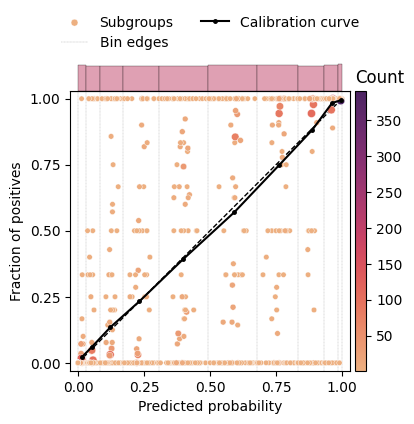

In [17]:
partitioner = Partitioner.from_name("decision_tree", n_bins=10, strategy="quantile", binwise_fit=False)

glest = GLEstimator(est, partitioner=partitioner, train_size=0.5, random_state=0)
glest.fit(X_test, y_test)
fig = glest.plot(fig_kw=dict(figsize=(4, 4)))
print(glest)
